In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import scale
from sklearn.metrics import mean_absolute_error, accuracy_score

In [2]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

TensorFlow version: 2.10.0
Num GPUs Available:  1
Num CPUs Available:  1



# Lab: Deep Learning

In this section, we show how to fit the examples discussed in the text. We use the `keras` package, which interfaces to the
`tensorflow` package. This code is
impressively fast, and the package is well-structured. A good companion
is the text **Deep Learning with Python**
(F. Chollet, _Deep Learning with Python_
  (2021), Manning Publications,) and most of our code is adapted from
there.

## Single Layer Network on Hitters Data

We start by fitting the models in Section 10.6.
We set up the data, and separate out a training and
test set.

In [25]:
Hitters = pd.read_csv('data/Hitters.csv')
Gitters = Hitters.dropna()
X = Gitters.drop(columns='Salary')
X_dummies = pd.get_dummies(X, drop_first=True)
y = Gitters.Salary

X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=1/3, random_state=13)

The linear model should be familiar, but we present it anyway.

In [35]:
lfit = LinearRegression().fit(X_train, y_train)
lpred = lfit.predict(X_test)
mean_absolute_error(lpred, y_test)

241.46973580260382

Next we fit the lasso.

In [37]:
Xs = scale(X_dummies)
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=1/3, random_state=13)

The `scale()` function standardizes the matrix so each column
has mean zero and variance one.

In [39]:
cvfit = LassoCV(max_iter=10000).fit(Xs_train, y_train)
cpred = cvfit.predict(Xs_test)
mean_absolute_error(cpred, y_test)

234.4814544892802

To fit the neural network, we first set up a model structure
that describes the network.

In [46]:
modnn = keras.Sequential([
    layers.Dense(units=50, activation='relu', input_shape=(Xs_train.shape[1],)),
    layers.Dropout(rate=0.4),
    layers.Dense(units=1)
])

We have created a vanilla model
object called `modnn`, and have added details about the successive
layers in a sequential manner as a list of layers.

The object `modnn` has a single hidden layer with 50 hidden units, and
a ReLU activation function. It then has a dropout layer, in which a
random 40% of the 50 activations from the previous layer are set to zero
during each iteration of the stochastic gradient descent
algorithm. Finally, the output layer has just one unit with no
activation function, indicating that the model provides a single
quantitative output.

Next we add details to  `modnn` that control the fitting
algorithm. Here we have simply followed the examples given in
the Keras book. We minimize squared-error loss as in
(10.22). The algorithm
tracks the mean absolute error on the training data, and
on validation data if it is supplied.

In [47]:
modnn.compile(
    loss='mse',
    optimizer='rmsprop',
    metrics=['mean_absolute_error']
)

The `compile()` function does not actually change the `Python`
object `modnn`, but it does communicate these specifications to
the corresponding instance of this model that has been created
along the way.

Now we fit the model. We supply the training data and two
fitting parameters, `epochs` and `batch_size`. Using 32
for the latter means that at each step of SGD, the algorithm randomly
selects 32 training observations for the computation of the gradient. Recall from
Sections 10.4 and 10.7
that an epoch amounts to the number of SGD steps required to process $n$
observations. Since the training set has
$n=176$, an epoch is $176/32=5.5$ SGD steps. The `fit()` function has an argument
`validation_data`; these data are not used in the fitting,
but can be used to track the progress of the model (in this case reporting
mean absolute error). Here we
actually supply the test data so we can see mean absolute error of both the
training data and test data as the epochs proceed.

In [ ]:
history = modnn.fit(
    Xs_train, y_train, epochs=600, batch_size=32,
    validation_data=(Xs_test, y_test)
)

*(Here and elsewhere we have reduced the number of epochs to make
    runtimes manageable; users can of course change back to epochs=1500)*

We can plot the `history` to display the mean absolute error for the training and test data.]

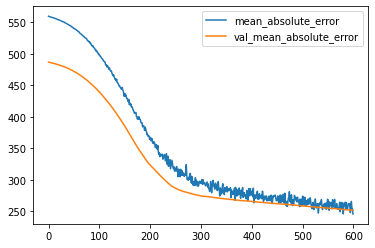

In [57]:
pd.DataFrame(history.history)[['mean_absolute_error', 'val_mean_absolute_error']].plot();

It is worth noting that if you run the `fit()` command a second time in the same `Python` session, then the fitting process will pick up where it left off. Try re-running the `fit()` command, and then the  plot, to see!

Finally, we predict from the final model, and
evaluate its performance on the test data. Due to the use of SGD, the results vary slightly with each
fit.

In [58]:
npred = modnn.predict(Xs_test)
mean_absolute_error(npred, y_test)

3/3 [==============================] - 0s 4ms/step


2022-10-26 09:41:25.642705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


252.05895891657744

## Multilayer Network on the MNIST Digit Data

The `keras` package comes with a number of example datasets,
including the `MNIST` digit data. Our first step is to load the
`MNIST` data. The `dataset_mnist()` function is provided for this purpose.

In [112]:
from keras.datasets import mnist, cifar100
from sklearn.metrics import accuracy_score

In [87]:
(x_train, g_train), (x_test, g_test) = mnist.load_data()
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


There are 60,000 images in the training data and 10,000 in the test data. The images are $28\times 28$, and stored as a three-dimensional array,
so we need to reshape them into a matrix.  Also, we need to ``one-hot''
encode the class label. Luckily `keras` has a lot of built-in
functions that do this for us.

In [88]:
x_train = x_train.reshape((-1,784))
x_test = x_test.reshape((-1,784))
y_train = keras.utils.to_categorical(g_train, 10)
y_test = keras.utils.to_categorical(g_test, 10)

Neural networks are somewhat sensitive to the scale of the inputs. For example, ridge and
lasso regularization are affected by scaling.  Here the inputs are eight-bit
(Note: Eight bits means $2^8$, which equals 256. Since the convention
is to start at $0$, the possible values  range from $0$ to $255$.)
grayscale values between 0 and 255, so we rescale to the unit
interval.

In [77]:
x_train = x_train / 255
x_test = x_test / 255

Now we are ready to fit our neural network.

In [98]:
modelnn = keras.Sequential([
    layers.Dense(units=256, activation='relu', input_shape=(784,)),
    layers.Dropout(rate=0.4),
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(rate=0.3),
    layers.Dense(units=10, activation='softmax')
])

The first layer goes from  $28\times28=784$ input units to a hidden
layer of $256$ units, which uses the ReLU activation function.
This is specified by a call to `layer.Dense()`.
Then we add `layer.Dropout()` to perform
dropout regularization. The second hidden layer comes
next, with $128$ hidden units, followed by a  dropout layer.
The final layer is the output layer, with activation
`"softmax"` (10.12) for the 10-class classification
problem, which defines the map from the second hidden layer to class
probabilities.
Finally, we use `summary()` to summarize the model, and to make sure we got it
all right.

In [99]:
modelnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 256)               200960    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


The parameters for each layer include a bias term, which results in a
parameter count of 235,146. For example, the first hidden
layer involves $(784+1)\times 256=200{,}960$ parameters.

Notice that the layer names such as `dropout_1` and
`dense_2` have subscripts. These may appear somewhat random; in
fact, if you fit the same model again, these will change. They are of
no consequence: they vary because the model
specification code is run in `python`, and these subscripts are incremented every time
`keras_model_sequential()` is called.

Next, we add details to the model to specify the fitting algorithm. We fit the model by minimizing the cross-entropy function given by (10.13).

In [100]:
modelnn.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

Now we are ready to go. The final step is to supply training data, and fit the model.

In [101]:
%%time
history = modelnn.fit(x_train, y_train, epochs=30, batch_size=128,
                     validation_split=0.2, verbose=False)

2022-10-26 10:14:17.246514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-26 10:14:19.753458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


CPU times: user 1min 19s, sys: 33 s, total: 1min 52s
Wall time: 1min 24s


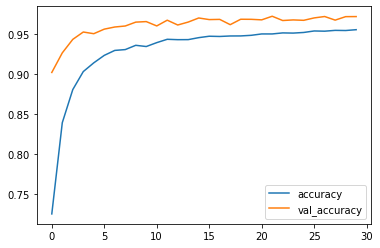

In [102]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot();

Here we specified a
validation split of 20%, so the training is actually performed on
80% of the 60,000 observations in the training set. This is an
alternative to actually supplying validation data, like we did in
Section 10.9.1. SGD  uses batches
of 128 observations in computing the gradient, and doing the
arithmetic, we see that an epoch corresponds to 375 gradient steps.
The last `plot()` command produces a figure similar to Figure 10.18.

To obtain the test error in Table 10.1, we first import
a simple function `accuracy()` that compares predicted and true
class labels, and then use it to evaluate our predictions.

In [103]:
accuracy_score(modelnn.predict(x_test).argmax(axis=1), g_test)

 95/313 [========>.....................] - ETA: 0s

2022-10-26 10:16:04.700805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step


0.9701

The table also reports LDA (Chapter 4) and multiclass logistic
regression. Although packages such as `glmnet` can handle
multiclass logistic regression, they are quite slow on this large
dataset. It is much faster and quite easy to fit such a model
using the `keras` software. We just have an input layer and output layer, and omit the hidden layers!

In [108]:
modellr = keras.Sequential([
    layers.Dense(input_shape=(784,), units=10, activation='softmax')
])
modellr.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


We fit the model just as before.

In [110]:
modellr.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
modellr.fit(x_train, y_train, epochs=30, batch_size=128, validation_split=0.2, verbose=False)
accuracy_score(modellr.predict(x_test).argmax(axis=1), g_test)

2022-10-26 10:20:14.147098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-26 10:20:16.097847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


117/313 [==========>...................] - ETA: 0s

2022-10-26 10:21:20.631025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 0s 1ms/step


0.9124

### Convolutional Neural Networks

In this section we fit a CNN to the `CIFAR` data, which is available in the `keras`
package. It is arranged in a similar fashion as the `MNIST` data.

In [116]:
(x_train, g_train), (x_test, g_test) = cifar100.load_data()
x_train.shape

(50000, 32, 32, 3)

The array of 50,000 training images has four dimensions:
  each three-color image is represented as a set of three channels, each of which consists of
$32\times 32$ eight-bit pixels. We standardize as we did for the
digits, but keep the array structure. We one-hot encode the response
factors  to produce a 100-column binary matrix.

In [117]:
x_train = x_train / 255
x_test = x_test / 255
y_train = keras.utils.to_categorical(g_train, 100)
y_train.shape

(50000, 100)

Before we start, we look at some of the training images using  the `imshow()` function; similar to
Figure 10.5 on page 411.

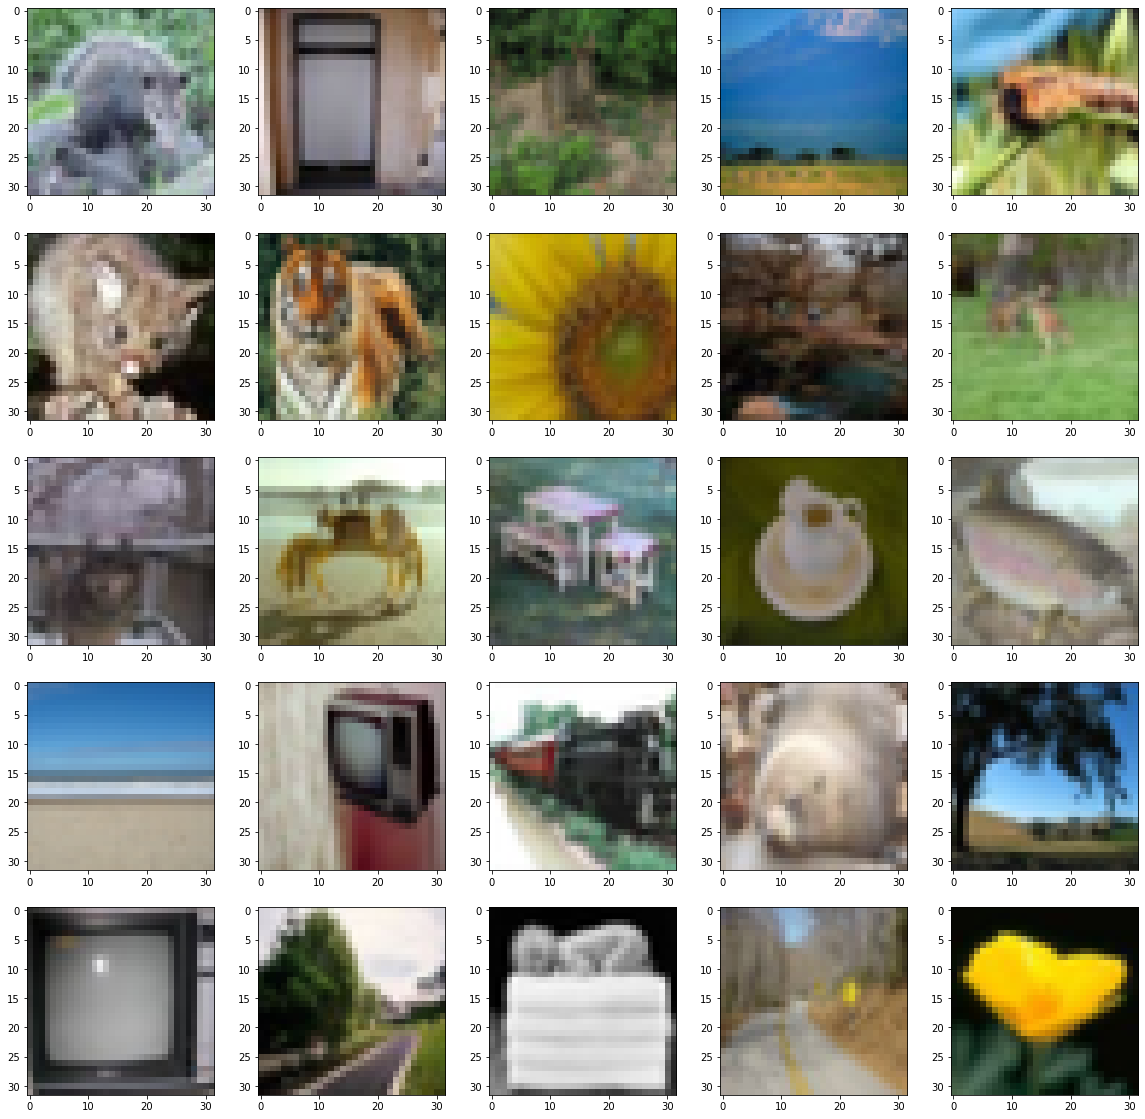

In [119]:
fig, axes = plt.subplots(5, 5, figsize=(20,20))
axes = axes.ravel()
index = np.random.choice(range(50000), size=25, replace=False)
for i, ax in zip(index, axes):
    ax.imshow(x_train[i])

Here we specify a moderately-sized  CNN for
demonstration purposes, similar in structure to Figure 10.8.

In [120]:
model = keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3),
                  padding='same', activation='relu',
                  input_shape=(32, 32, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3),
                  padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=128, kernel_size=(3, 3),
                  padding='same', activation='relu',
                  input_shape=(32, 32, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=256, kernel_size=(3, 3),
                  padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(rate=0.5),
    layers.Dense(units=512, activation='relu'),
    layers.Dense(units=100, activation='softmax')
])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)       

Notice that we used the `padding='same'` argument to
`layers.Conv2D()`, which ensures that the output channels have the
same dimension as the input channels. There are 32 channels in the first
hidden layer, in contrast to the three channels in the input layer. We
use a $3\times 3$ convolution filter for each channel in all the layers. Each
convolution is followed by a max-pooling layer over $2\times2$
blocks. By studying the summary, we can see that the channels halve in both
dimensions
after each of these max-pooling operations. After the last of these we
have a layer with  256 channels of dimension $2\times 2$. These are then
flattened to a dense layer of size 1,024:
in other words, each of the $2\times 2$ matrices is turned into a
$4$-vector, and put side-by-side in one layer. This is followed by a
dropout regularization layer,  then
another dense layer of size 512, which finally reaches the softmax
output layer.

Finally, we specify the fitting algorithm, and fit the model.

In [121]:
%%time
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=30, batch_size=128, validation_split=0.2, verbose=False)
accuracy_score(model.predict(x_test).argmax(axis=1), g_test)

2022-10-26 10:51:22.704269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-26 10:51:29.209405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 74/313 [======>.......................] - ETA: 0s

2022-10-26 10:54:00.018165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
CPU times: user 1min 56s, sys: 50.6 s, total: 2min 47s
Wall time: 2min 38s


0.4412

This model takes 10 minutes to run and achieves 44% accuracy on the test
data. Although this is not terrible for 100-class data (a random
classifier gets 1% accuracy), searching the web we see results around
75%. Typically it takes a lot of architecture carpentry,
fiddling with regularization, and time to achieve such results.

## Using Pretrained CNN Models

We now show how to use a CNN pretrained on the  `imagenet` database to classify natural
images, and demonstrate how we produced Figure 10.10
We copied six jpeg images from a digital photo album into the
directory `book_images`. We first read in the images, and
convert them into the array format expected by the `keras`
software to match the specifications in `imagenet`.

In [173]:
from pathlib import Path
from PIL import Image
from pprint import pprint

In [162]:
img_dir = Path('./data/book_images/')
image_names = list(img_dir.glob('*'))
num_images = len(image_names)
x = np.zeros((num_images, 224, 224, 3), dtype=int)
for i, img_path in enumerate(image_names):
    img = Image.open(img_path)
    img_small = np.array(img.resize((224, 224)))
    x[i] = img_small
    img.close()
x = keras.applications.imagenet_utils.preprocess_input(x)

We then load the trained network. The model has 50 layers, with a fair bit of complexity.

In [166]:
model = keras.applications.ResNet50(weights='imagenet')
model.summary()

102967424/102967424 [==============================] - 8s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

Finally, we classify our six images, and return the top three class
choices in terms of predicted probability for each.

In [174]:
pred6 = model.predict(x)
pred6 = keras.applications.imagenet_utils.decode_predictions(pred6, top=3)
for img, p in zip(image_names, pred6):
    print(img.stem)
    pprint(p)

1/1 [==============================] - 0s 24ms/step
weaver
[('n01843065', 'jacamar', 0.30668205),
 ('n01818515', 'macaw', 0.13143706),
 ('n02494079', 'squirrel_monkey', 0.073846325)]
flamingo
[('n02007558', 'flamingo', 0.94361556),
 ('n02006656', 'spoonbill', 0.05392085),
 ('n02002556', 'white_stork', 0.0012582844)]
huey
[('n02098413', 'Lhasa', 0.69261575),
 ('n02097474', 'Tibetan_terrier', 0.21974169),
 ('n02102318', 'cocker_spaniel', 0.025099773)]
hawk_cropped
[('n01608432', 'kite', 0.9616998),
 ('n01622779', 'great_grey_owl', 0.01068411),
 ('n01558993', 'robin', 0.004340519)]
hawk
[('n01608432', 'kite', 0.22476025),
 ('n03532672', 'hook', 0.15727003),
 ('n01616318', 'vulture', 0.1047971)]
kitty
[('n02105641', 'Old_English_sheepdog', 0.44424218),
 ('n03223299', 'doormat', 0.15851563),
 ('n02123394', 'Persian_cat', 0.04863337)]


## IMDb Document Classification

Now we perform document classification (Section 10.4) on the `IMDB` dataset, which is available as part of the `keras`
package. We  limit the dictionary size to the
10,000  most frequently-used words and tokens.

In [2]:
from keras.datasets import imdb

In [3]:
max_features = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

Each element of `x_train` is a vector of numbers between 0 and
9999 (the document), referring to the words found in the dictionary.
For example, the first training document is the positive review on
page  419. The indices of the first 12 words are given below.

In [5]:
x_train[0][0:12]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468]

To see the words, we create a function, `decode_review()`, that provides a simple interface to the dictionary.

In [6]:
word_index = imdb.get_word_index()

# We invert the dictionary and add special characters
# Note we add 3 to the keys to recover the actual indices
inverse_index = {v+3: k for k, v in word_index.items()}
inverse_index[0] = '<PAD>'
inverse_index[1] = '<START>'
inverse_index[2] = '<UNK>'
inverse_index[3] = '<UNUSED>'

def decode_review(text, word_index):
    words = [word_index[i] for i in text]
    return ' '.join(words)

In [7]:
decode_review(x_train[0][0:12], inverse_index)

"<START> this film was just brilliant casting location scenery story direction everyone's"

Next we write a function to *one-hot* encode each document in a list
of documents, and return a binary matrix in sparse-matrix format.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix

In [9]:
def one_hot(sequences, dimension):
    row = [i for i, seq in enumerate(sequences) for word in seq]
    n = len(sequences)
    col = np.concatenate(sequences).ravel()
    data = np.ones_like(col)
    return (csr_matrix((data, (row, col)), shape=(n, dimension)) > 0).astype(float)

To construct the sparse matrix, one supplies just the entries that are
nonzero. In the last line we call the function `sparseMatrix()` and supply the
row indices corresponding to each document and the column indices
corresponding to the words in each document.
Words that appear more than once in any given document still get
recorded as a one.

In [10]:
x_train_1h = one_hot(x_train, 10000)
x_test_1h = one_hot(x_test, 10000)
print(x_train_1h.shape)
print(x_train_1h.nnz / (25000 * 10000))

(25000, 10000)
0.013169872


Only 1.3% of the entries are nonzero, so this amounts to considerable
savings in memory.
We create a validation set of size 2,000, leaving 23,000 for training.

In [11]:
x_train_1h_v, x_val_1h, y_train_v, y_val = train_test_split(x_train_1h, y_train, test_size=2000)

First we fit a lasso logistic regression model using Scikit-Learn
on the training data, and evaluate its performance on the validation
data. Finally, we plot the accuracy as a function of
the shrinkage parameter, $\lambda$. Similar expressions compute the
performance on the test data, and were used to produce the left plot
in Figure 10.11.

The code  takes advantage of the sparse-matrix format of
`x_train_1h`.

In [35]:
%%time
from sklearn.svm import l1_min_c
from sklearn.linear_model import LogisticRegression

# C_min is 1/(N*alpha_max)
alpha_max = 1/(l1_min_c(x_train_1h_v, y_train_v, loss='log')*len(y_train_v))
alpha_min = 0.0001*alpha_max
alpha_grid = np.geomspace(alpha_max, alpha_min, 100)
c_grid = 1/(alpha_grid*len(y_train_v))

clf = LogisticRegression(penalty="l1", warm_start=True, solver="liblinear", max_iter=1e6)

acc_train = []
acc_val = []
acc_test = []
for c in c_grid:
    clf.set_params(C=c)
    clf.fit(x_train_1h_v, y_train_v)
    
    preds_train = clf.predict(x_train_1h_v)
    acc_train.append(accuracy_score(preds_train, y_train_v))
    
    preds_val = clf.predict(x_val_1h)
    acc_val.append(accuracy_score(preds_val, y_val))
    
    preds_test = clf.predict(x_test_1h)
    acc_test.append(accuracy_score(preds_test, y_test))

CPU times: user 42.6 s, sys: 1.21 s, total: 43.9 s
Wall time: 43.2 s


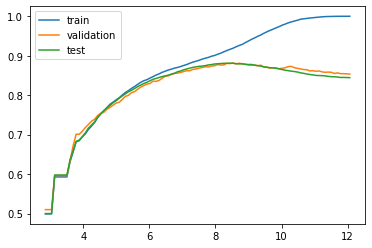

In [36]:
plt.plot(-np.log(alpha_grid), acc_train, label='train')
plt.plot(-np.log(alpha_grid), acc_val, label='validation')
plt.plot(-np.log(alpha_grid), acc_test, label='test')
plt.legend();

Next we fit a fully-connected neural network with two hidden layers,
each with 16 units and ReLU activation.

In [39]:
model = keras.Sequential([
    layers.Dense(units=16, activation='relu', input_shape=(10000,)),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=1, activation='sigmoid')
])

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(x_train_1h_v, y_train_v, epochs=20, batch_size=512,
                      validation_data=(x_val_1h, y_val), verbose=False)

/opt/homebrew/Caskroom/mambaforge/base/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_2/dense_6/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_2/dense_6/embedding_lookup_sparse/Reshape:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_2/dense_6/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
2022-11-15 14:44:45.554148: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-15 14:44:45.554526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 14:44:49.605203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.

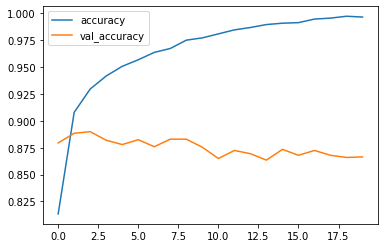

In [40]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot();

The `history` object has a `metrics` component that
records both the training and validation accuracy at each epoch.
Figure 10.11 includes test accuracy at each epoch as well. To
compute the test accuracy, we
rerun the entire sequence above, replacing the last line with

In [ ]:
history = modelnn.fit(x_train_1h_v, y_train_v, epochs=20, batch_size=512,
                      validation_data=(x_test_1h, y_test), verbose=False)

## Recurrent Neural Networks

In this lab we fit the models illustrated in
Section 10.5.

### Sequential Models for Document Classification

Here we  fit a simple  LSTM RNN for sentiment analysis with
the `IMDB` movie-review data, as discussed in Section 10.5.1. We showed how to input the data in
10.9.5, so we will not repeat that here.

We first calculate the lengths of the documents.


In [4]:
wc = np.array([len(x) for x in x_train])
print(np.percentile(wc, 50))
np.sum(wc <= 500) / len(wc)

178.0


0.91568

We see that over 91% of the documents have fewer than 500 words. Our
RNN requires all the document sequences to have the same length. We hence
restrict the document lengths to the last $L=500$ words, and pad the
beginning of the
shorter ones with blanks.

In [5]:
maxlen = 500
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_test = keras.utils.pad_sequences(x_test, maxlen=maxlen)
print(x_train.shape)
print(x_test.shape)
x_train[0, 489:500]

(25000, 500)
(25000, 500)


array([  16, 4472,  113,  103,   32,   15,   16, 5345,   19,  178,   32],
      dtype=int32)

The last expression shows the last few words in the first document. At this stage, each of the 500 words in the document  is represented using an integer
corresponding to the location of that word in the 10,000-word dictionary.
The first layer of the RNN is an embedding layer of size 32, which will be
learned during  training. This layer one-hot encodes  each document
as a matrix of dimension $500 \times 10,000$, and then maps these
$10,000$ dimensions down to $32$.

In [6]:
model = keras.Sequential([
    layers.Embedding(input_dim=10000, output_dim=32),
    layers.LSTM(units=32),
    layers.Dense(units=1, activation='sigmoid')
])

Metal device set to: Apple M1 Pro


2022-11-15 16:20:27.156523: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-15 16:20:27.156770: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


The second  layer is an LSTM with 32 units, and the output
layer is a single sigmoid for the binary classification task.

The rest is now similar to other networks we have fit. We
track the test performance as the network is fit, and see that it attains 87\% accuracy.

In [16]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
history = model.fit(x_train, y_train, epochs=3, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/3


2022-11-15 16:33:05.077443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 16:33:05.212271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 16:33:06.395935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - ETA: 0s - loss: 0.1507 - acc: 0.9481

2022-11-15 16:33:54.334091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 16:33:54.384311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - 66s 309ms/step - loss: 0.1507 - acc: 0.9481 - val_loss: 0.3651 - val_acc: 0.8668
Epoch 2/3
196/196 [==============================] - 53s 272ms/step - loss: 0.1407 - acc: 0.9528 - val_loss: 0.6978 - val_acc: 0.7969
Epoch 3/3
196/196 [==============================] - 53s 271ms/step - loss: 0.1357 - acc: 0.9539 - val_loss: 0.3750 - val_acc: 0.8636


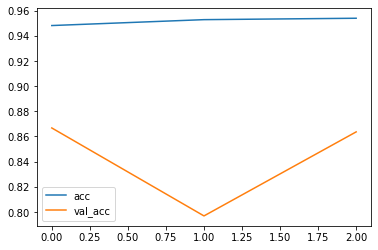

In [17]:
pd.DataFrame(history.history)[['acc', 'val_acc']].plot();

In [24]:
predy = model.predict(x_test, batch_size=128)

196/196 [==============================] - 16s 75ms/step


In [25]:
((predy > 0.5).astype(int) == y_test[:, None]).mean()

0.86364

###  Time Series Prediction

We now show how to fit the models in Section 10.5.2
for  time series prediction.
We first set up the data, and standardize each of the variables.

In [3]:
from sklearn.preprocessing import scale

In [70]:
NYSE = pd.read_csv('data/NYSE.csv')
xdata = NYSE[["DJ_return", "log_volume","log_volatility"]]
istrain = NYSE['train'].values
xdata = pd.DataFrame(scale(xdata), columns=xdata.columns)

The  variable `istrain` contains a `TRUE` for each year that  is in the training set, and a `FALSE` for each year
 in the test set.

We first write functions to create lagged versions of the three time series.  We start with a function that takes as input a data
matrix and a lag $L$, and returns a lagged version of the matrix. It
simply inserts $L$ rows of `NA` at the top, and truncates the
bottom.

In [71]:
def lagm(x, k=1):
    col_names = [f'L{k}_{c}' for c in x.columns]
    x = x.values.copy()
    n = x.shape[0]
    lagged = np.full_like(x, np.nan, dtype=float)
    lagged[k:] = x[:-k, :]
    return pd.DataFrame(lagged, columns=col_names)

We now use this function to create a data frame with all the required
lags, as well as the response variable.

In [74]:
arframe = pd.concat([
    xdata[['log_volume']],
    lagm(xdata, 1),
    lagm(xdata, 2),
    lagm(xdata, 3),
    lagm(xdata, 4),
    lagm(xdata, 5)
], axis=1)
arframe.head()

,log_volume,L1_DJ_return,L1_log_volume,L1_log_volatility,L2_DJ_return,L2_log_volume,L2_log_volatility,L3_DJ_return,L3_log_volume,L3_log_volatility,L4_DJ_return,L4_log_volume,L4_log_volatility,L5_DJ_return,L5_log_volume,L5_log_volatility
0,0.175075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.517291,-0.549823,0.175075,-4.357078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.283789,0.905200,1.517291,-2.529058,-0.549823,0.175075,-4.357078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.935176,0.434813,2.283789,-2.418037,0.905200,1.517291,-2.529058,-0.549823,0.175075,-4.357078,NaN,NaN,NaN,NaN,NaN,NaN
4,0.224779,-0.431397,0.935176,-2.366521,0.434813,2.283789,-2.418037,0.905200,1.517291,-2.529058,-0.549823,0.175075,-4.357078,NaN,NaN,NaN


If we look at the first five rows of this frame, we will see some
missing values in the lagged variables (due to the construction above). We remove these rows, and adjust `istrain`
accordingly.

In [76]:
arframe = arframe.iloc[5:]
istrain = istrain[5:]

We now fit the linear AR model to the training data using `lm()`, and predict on the
test data.

In [120]:
X_train = arframe[istrain].drop(columns='log_volume')
y_train = arframe[istrain]['log_volume']
X_test = arframe[~istrain].drop(columns='log_volume')
y_test = arframe[~istrain]['log_volume']

arfit = LinearRegression().fit(X_train, y_train)
arpred = arfit.predict(X_test)
arfit.score(X_test, y_test)

0.4128912938562521

The last line compute the $R^2$ on the test data.

We refit this model, including the factor variable `day_of_week`.

In [122]:
day_df = pd.get_dummies(NYSE[['day_of_week']], drop_first=True).iloc[5:].set_index(arframe.index)
arframed = pd.concat([arframe, day_df], axis=1)

X_train = arframed[istrain].drop(columns='log_volume')
y_train = arframed[istrain]['log_volume']
X_test = arframed[~istrain].drop(columns='log_volume')
y_test = arframed[~istrain]['log_volume']

arfitd = LinearRegression().fit(X_train, y_train)
arpredd = arfitd.predict(X_test)
arfitd.score(X_test, y_test)

0.45955631330532765

To fit the RNN, we need to reshape these data, since it expects a
sequence of $L=5$ feature vectors $X=\{X_\ell\}_1^L$ for each observation, as in (10.20) on
page  428. These are  lagged versions of the
time series going back $L$ time points.

In [141]:
n = len(arframe)
xrnn = arframe.values[:, 1:].copy()
xrnn = xrnn.reshape((n, 5, 3))
xrnn = np.flip(xrnn, axis=1)
xrnn.shape

(6046, 5, 3)

We have done this in three steps. The first simply extracts the
$n\times 15$ matrix of lagged versions of the three predictor
variables from `arframe`. The second converts this matrix to a
$n\times 5\times 3$ array. The third step reverses the order of lagged variables, so that index $0$
is furthest back in time, and index $4$ closest.

Now we are ready to proceed with the RNN, which uses 12 hidden units.

In [142]:
model = keras.Sequential([
    layers.SimpleRNN(units=12, input_shape=(5, 3), dropout=0.1, recurrent_dropout=0.1),
    layers.Dense(units=1)
])

model.compile(optimizer='rmsprop', loss='mse')

Metal device set to: Apple M1 Pro


2022-11-16 11:00:21.047026: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-16 11:00:21.047366: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


We specify two forms of dropout for the units feeding into the  hidden
 layer. The first is for
the input sequence feeding into this layer, and the second is for the
previous hidden units feeding into the layer.
The output layer has a single unit for the response.

We  fit the model in a similar fashion to previous networks. We
supply the `fit` function with test data as validation data, so that when
we monitor its progress and plot the history function we can see the
progress on the test data. Of course we should not use this as a basis for
early stopping, since then the test performance would be biased.


In [145]:
kpred

array([[-0.5092772 ],
       [ 0.34618524],
       [ 0.43375787],
       ...,
       [-1.1524459 ],
       [-1.1723648 ],
       [-1.0881433 ]], dtype=float32)

In [146]:
1 - np.mean((kpred.ravel() - y_val)**2) / np.var(y_val, ddof=1)

0.4136206539716858

In [147]:
%%time
X_train = xrnn[istrain]
y_train = arframe[istrain]['log_volume'].values
X_val = xrnn[~istrain]
y_val = arframe[~istrain]['log_volume'].values

history = model.fit(X_train, y_train, batch_size=64, epochs=200, validation_data=(X_val, y_val))
kpred = model.predict(X_val, batch_size=64)

# Calculate R^2
1 - np.mean((kpred.ravel() - y_val)**2) / np.var(y_val, ddof=1)

Epoch 1/200
67/67 [==============================] - 2s 29ms/step - loss: 0.4551 - val_loss: 0.6173
Epoch 2/200
67/67 [==============================] - 2s 28ms/step - loss: 0.4606 - val_loss: 0.6242
Epoch 3/200
67/67 [==============================] - 2s 28ms/step - loss: 0.4506 - val_loss: 0.6196
Epoch 4/200
67/67 [==============================] - 2s 28ms/step - loss: 0.4515 - val_loss: 0.6176
Epoch 5/200
67/67 [==============================] - 2s 28ms/step - loss: 0.4504 - val_loss: 0.6237
Epoch 6/200
67/67 [==============================] - 2s 28ms/step - loss: 0.4483 - val_loss: 0.6156
Epoch 7/200
67/67 [==============================] - 2s 28ms/step - loss: 0.4559 - val_loss: 0.6205
Epoch 8/200
67/67 [==============================] - 2s 28ms/step - loss: 0.4572 - val_loss: 0.6195
Epoch 9/200
67/67 [==============================] - 2s 28ms/step - loss: 0.4560 - val_loss: 0.6205
Epoch 10/200
67/67 [==============================] - 2s 29ms/step - loss: 0.4620 - val_loss: 0.6241

0.41049592990937445

This model takes about ten minutes to train.

We could replace the  `keras_model_sequential()`  command above with the following command:

In [ ]:
model = keras.Sequential([
    layers.Flatten(input_shape=(5,3)),
    layers.Dense(units=1)
])

Here, `Flatten()` simply takes the input sequence and
turns it into a long vector of predictors. This results in a linear AR model.
To fit a nonlinear AR model, we could add in a hidden layer.

However, since we already have the matrix of lagged variables from the AR
model that we fit earlier using the `lm()` command, we can actually fit a nonlinear AR model without needing to perform flattening.
We extract the model matrix `x` from `arframed`, which
includes the `day_of_week` variable.

In [150]:
day_df_full = pd.get_dummies(NYSE[['day_of_week']], drop_first=False).iloc[5:].set_index(arframe.index)
x = pd.concat([arframe, day_df_full], axis=1).drop(columns='log_volume')
x.columns

Index(['L1_DJ_return', 'L1_log_volume', 'L1_log_volatility', 'L2_DJ_return',
       'L2_log_volume', 'L2_log_volatility', 'L3_DJ_return', 'L3_log_volume',
       'L3_log_volatility', 'L4_DJ_return', 'L4_log_volume',
       'L4_log_volatility', 'L5_DJ_return', 'L5_log_volume',
       'L5_log_volatility', 'day_of_week_fri', 'day_of_week_mon',
       'day_of_week_thur', 'day_of_week_tues', 'day_of_week_wed'],
      dtype='object')

The rest of the steps to fit a nonlinear AR model should by now be familiar.

In [151]:
%%time
X_train = x.values[istrain]
X_val = x.values[~istrain]

arnnd = keras.Sequential([
    layers.Dense(units=32, activation='relu', input_shape=(x.shape[1],)),
    layers.Dropout(rate=0.5),
    layers.Dense(units=1)
])

arnnd.compile(loss='mse', optimizer='rmsprop')

history = arnnd.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
  9/134 [=>............................] - ETA: 0s - loss: 1.7732 

2022-11-16 13:12:46.844777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


134/134 [==============================] - ETA: 0s - loss: 1.0252

2022-11-16 13:12:47.779127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


134/134 [==============================] - 1s 8ms/step - loss: 1.0252 - val_loss: 0.7172
Epoch 2/100
134/134 [==============================] - 1s 6ms/step - loss: 0.6466 - val_loss: 0.6373
Epoch 3/100
134/134 [==============================] - 1s 7ms/step - loss: 0.5475 - val_loss: 0.6113
Epoch 4/100
134/134 [==============================] - 1s 7ms/step - loss: 0.4919 - val_loss: 0.5973
Epoch 5/100
134/134 [==============================] - 1s 7ms/step - loss: 0.4739 - val_loss: 0.5888
Epoch 6/100
134/134 [==============================] - 1s 7ms/step - loss: 0.4697 - val_loss: 0.5803
Epoch 7/100
134/134 [==============================] - 1s 7ms/step - loss: 0.4519 - val_loss: 0.5769
Epoch 8/100
134/134 [==============================] - 1s 6ms/step - loss: 0.4523 - val_loss: 0.5775
Epoch 9/100
134/134 [==============================] - 1s 6ms/step - loss: 0.4465 - val_loss: 0.5741
Epoch 10/100
134/134 [==============================] - 1s 7ms/step - loss: 0.4327 - val_loss: 0.5725
E

56/56 [==============================] - 0s 2ms/step


2022-11-16 13:15:11.898575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.46586290659518836

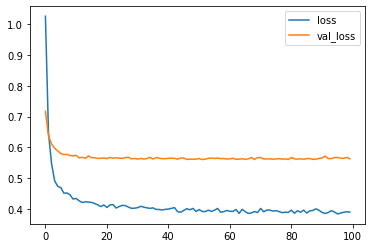

In [155]:
pd.DataFrame(history.history).plot();

npred = arnnd.predict(X_val, batch_size=32)

1 - np.mean((npred.ravel() - y_val)**2) / np.var(y_val, ddof=1)